In [ ]:
import dgeb
from datasets import load_dataset
import pandas as pd
import torch
import os
import numpy as np
import argparse
import logging
from collections import Counter
import matplotlib.pyplot as plt

from itertools import product
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import v_measure_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.mixture import GaussianMixture


/home/chengyudu_umass_edu/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
ecoli_ds = load_dataset("tattabio/rna_clustering",  split="train")
mopb_ds  = load_dataset("tattabio/mopb_clustering",  split="train")

In [18]:
print("Ecoli_RNA data：", ecoli_ds)
print("MopB     data：", mopb_ds)

Ecoli_RNA data： Dataset({
    features: ['Sequence', 'Label'],
    num_rows: 161
})
MopB     data： Dataset({
    features: ['Entry', 'Sequence', 'Label'],
    num_rows: 1300
})


In [21]:
prot_counts = Counter(mopb_ds["Label"])
prot_counts

Counter({'DmsA': 100,
         'NarG': 100,
         'ActB': 100,
         'Nqo3': 100,
         'Fdhs': 100,
         'NasCNarB': 100,
         'FdhG': 100,
         'FwdB': 100,
         'TtrASrdA': 100,
         'PsrAPhsA': 100,
         'DorATorA': 100,
         'NapA': 100,
         'AH': 100})

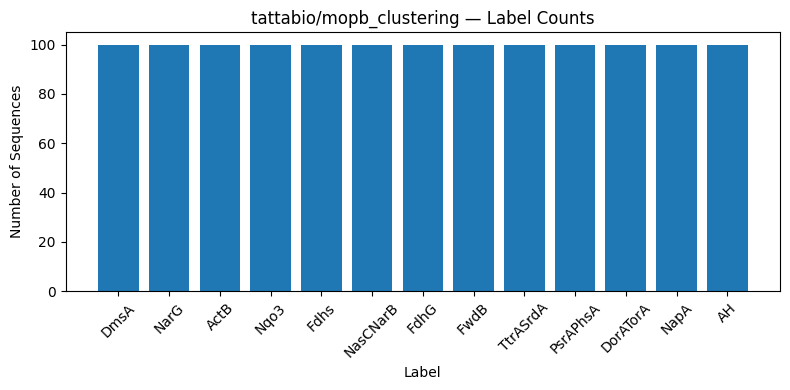

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(prot_counts.keys(), prot_counts.values())
plt.title("tattabio/mopb_clustering — Label Counts")
plt.xlabel("Label")
plt.ylabel("Number of Sequences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
rna_counts = Counter(ecoli_ds["Label"])
rna_counts

Counter({'sRNA': 100, 'tRNA': 45, 'rRNA': 16})

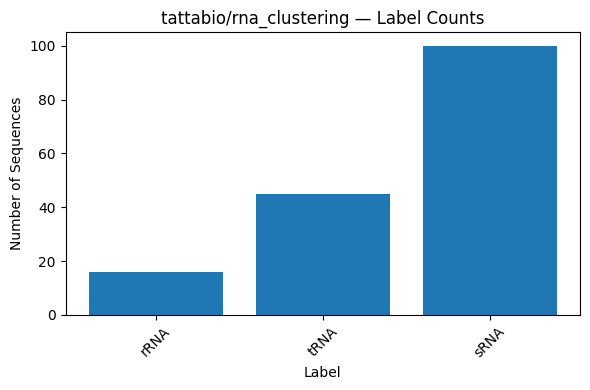

In [24]:
plt.figure(figsize=(6,4))
plt.bar(rna_counts.keys(), rna_counts.values())
plt.title("tattabio/rna_clustering — Label Counts")
plt.xlabel("Label")
plt.ylabel("Number of Sequences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:

def get_kmer_features(sequences, k):
    """
    Build normalized k-mer frequency features.
    """
    vec = CountVectorizer(analyzer='char', ngram_range=(k, k))
    X_counts = vec.fit_transform(sequences)
    return normalize(X_counts.astype(float), norm='l1', axis=1)

# Define meaningful k values based on alphabet size and sequence count
k_values = {
    'rna': [2, 3, 4],    # RNA: 4^k dims = 16, 64, 256
    'prot': [2, 3]       # Protein: 20^k dims = 400, 8000
}

# Load data
rna_ds  = load_dataset("tattabio/rna_clustering", split="train")
prot_ds = load_dataset("tattabio/mopb_clustering", split="train")

results = []

# Loop over datasets and k values
for name, dataset in [('RNA', rna_ds), ('Protein', prot_ds)]:
    seqs       = dataset["Sequence"]
    labels     = dataset["Label"]
    n_clusters = len(set(labels))
    
    for k in (k_values['rna'] if name == 'RNA' else k_values['prot']):
        # Extract k-mer features
        X = get_kmer_features(seqs, k)
        X_arr = X.toarray()
        
        # 1) K-Means
        km = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
        v_km = v_measure_score(labels, km.labels_)
        
        # 2) Hierarchical clustering (Ward linkage)
        hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(X_arr)
        v_hc = v_measure_score(labels, hc.labels_)
        
        # 3) Gaussian Mixture Model
        gmm = GaussianMixture(n_components=n_clusters, random_state=0).fit(X_arr)
        v_gmm = v_measure_score(labels, gmm.predict(X_arr))
        
        # Record results
        for method, v in [('KMeans', v_km),
                          ('Hierarchical', v_hc),
                          ('GMM', v_gmm)]:
            results.append({
                'Dataset': name,
                'k': k,
                'Method': method,
                'V-Measure': v
            })

# Display results
df_results = pd.DataFrame(results)
print(df_results.pivot_table(index=['Dataset','k'], columns='Method', values='V-Measure'))



Method          GMM  Hierarchical    KMeans
Dataset k                                  
Protein 2  0.484489      0.653290  0.484489
        3  0.650243      0.839109  0.591697
RNA     2  0.372450      0.362904  0.334168
        3  0.377878      0.303148  0.377878
        4  0.468416      0.139383  0.468416
